In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pathlib import Path


root = Path("~/data/ai4animals/sensor_eda/ticc/v5").expanduser()

with (root / "fit/ticc_output.pkl").open("rb") as f:
    cluster, mrfs = pickle.load(f)

cluster.shape, mrfs[0].shape

((10541,), (75, 75))

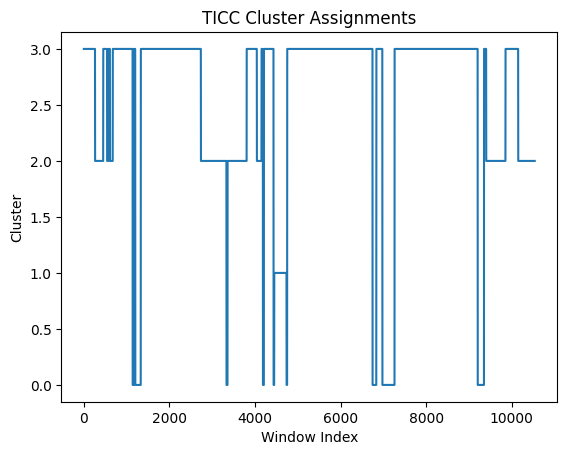

In [15]:
plt.plot(cluster)
plt.title("TICC Cluster Assignments")
plt.xlabel("Window Index")
plt.ylabel("Cluster")
plt.show()

In [16]:
# read in the original data
from collections import Counter

original = pd.read_csv(root / "fit/original_labels.csv")
y = original.behaviourId.values
y.shape, Counter(y)

((10565,),
 Counter({np.int64(0): 5780,
          np.int64(1): 3328,
          np.int64(2): 752,
          np.int64(3): 705}))

In [17]:
# create mapping from behaviorId to behavior
behaviour_mapping = original[["behaviourId", "behaviour"]].drop_duplicates().set_index("behaviourId")["behaviour"].to_dict()
behaviour_mapping

{3: 'walking', 1: 'headbutt', 0: 'drinking_milk', 2: 'running'}

In [18]:
y_pred = cluster.flatten()
y_pred.shape, Counter(y_pred)

((10541,),
 Counter({np.float64(3.0): 7210,
          np.float64(2.0): 2281,
          np.float64(0.0): 762,
          np.float64(1.0): 288}))

In [19]:
y_trunc = y[: len(y_pred)]

In [20]:
# count the number of switches in original and prediced
switches = np.sum(y_trunc[1:] != y_trunc[:-1])
total = len(y_trunc)
print(f"Number of switches in original: {switches} out of {total} ({switches/total:.2%})")

switches = np.sum(y_pred[1:] != y_pred[:-1])
total = len(y_pred)
print(f"Number of switches in predicted: {switches} out of {total} ({switches/total:.2%})")

Number of switches in original: 17 out of 10541 (0.16%)
Number of switches in predicted: 31 out of 10541 (0.29%)


In [21]:
# now let's try to match the clusters so we get the best match to the original
from sklearn.metrics import confusion_matrix

# find the best mapping of clusters to original labels

cm = confusion_matrix(y_trunc, y_pred)
cm

array([[  21,    5,    9, 5745],
       [ 127,    0, 2262,  915],
       [ 580,    0,    0,  172],
       [  34,  283,   10,  378]])

In [22]:
# brute force search for the best mapping using the hungarian algorithm
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(-cm)

# predicted to original mapping
mapping = {int(col): int(row) for row, col in zip(row_ind, col_ind)}

row_ind, col_ind, mapping

(array([0, 1, 2, 3]), array([3, 2, 0, 1]), {3: 0, 2: 1, 0: 2, 1: 3})

In [23]:
y_pred_mapped = np.array([mapping[c] for c in y_pred])
y_pred_mapped.shape, Counter(y_pred_mapped)

((10541,),
 Counter({np.int64(0): 7210,
          np.int64(1): 2281,
          np.int64(2): 762,
          np.int64(3): 288}))

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_trunc, y_pred_mapped))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88      5780
           1       0.99      0.68      0.81      3304
           2       0.76      0.77      0.77       752
           3       0.98      0.40      0.57       705

    accuracy                           0.84     10541
   macro avg       0.88      0.71      0.76     10541
weighted avg       0.87      0.84      0.83     10541



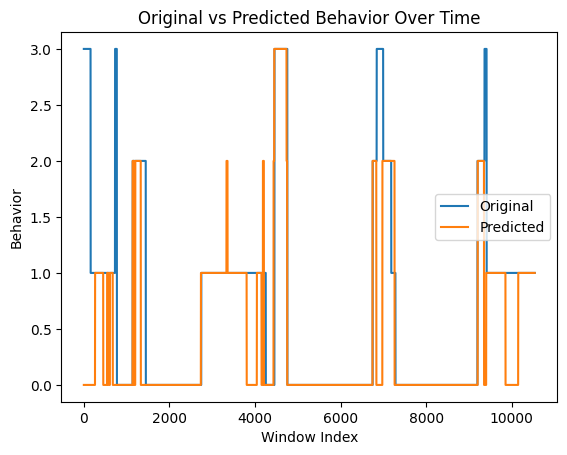

In [25]:
plt.plot(y_trunc, label="Original")
plt.plot(y_pred_mapped, label="Predicted")
plt.legend()
plt.title("Original vs Predicted Behavior Over Time")
plt.xlabel("Window Index")
plt.ylabel("Behavior")
# show the first 1000 only
# plt.xlim(0, 5000)
plt.show()

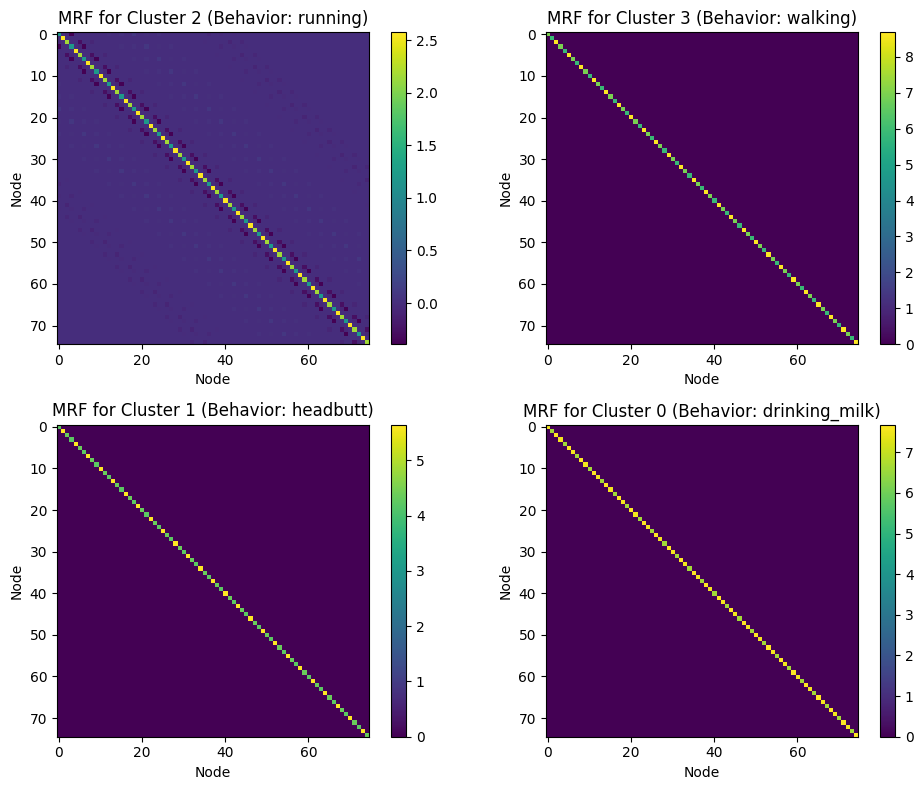

In [26]:
# now lets look at the MRFs and see how we can interpret these
import networkx as nx

# there are 4 clusters, so plot these on the same plot
axes = plt.subplots(2, 2, figsize=(10, 8))[1].flatten()
for i, (ax, mrf) in enumerate(zip(axes, mrfs.values())):
    ax.imshow(mrf)
    j = mapping[i]
    behavior = behaviour_mapping[j]
    ax.set_title(f"MRF for Cluster {j} (Behavior: {behavior})")
    ax.set_xlabel("Node")
    ax.set_ylabel("Node")
    plt.colorbar(mappable=ax.images[0], ax=ax)
plt.tight_layout()
plt.show()

In [27]:
def analyze_mrf(mrf, title="MRF Graph"):
   # convert this to a graph
   data = mrf.copy()
   # set the diagonal to 0
   np.fill_diagonal(data, 0)

   G = nx.from_numpy_array(np.abs(data), create_using=nx.Graph)
   # prune all edges with weight < 1e-8
   G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if abs(d["weight"]) < 1e-6])
   
   # draw the cluster
   pos = nx.spring_layout(G)
   nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
   plt.title(title)
   plt.show() 

   # describe summary of G
   print(f"Number of nodes: {G.number_of_nodes()}")
   print(f"Number of edges: {G.number_of_edges()}")

   # use betweenness centrality to find the most important nodes
   betweenness = nx.betweenness_centrality(G, weight="weight")
   # average each of the features
   scores = {0:[], 1:[], 2:[]}
   for node, score in betweenness.items():
      feature = node % 3
      scores[feature].append(score)
   avg_scores = {k: np.mean(v) for k, v in scores.items()}
   print(f"Average betweenness centrality by feature: {avg_scores}")
   return avg_scores, G

Cluster 2 (Behavior: running)


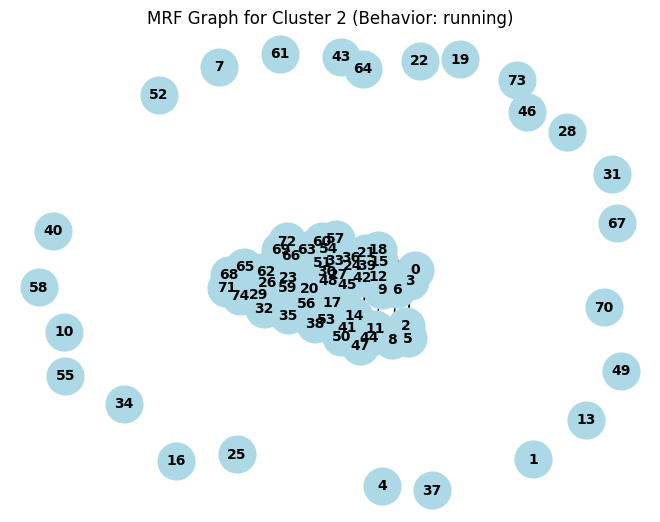

Number of nodes: 75
Number of edges: 424
Average betweenness centrality by feature: {0: np.float64(0.023324694557571274), 1: np.float64(0.0), 2: np.float64(0.0097741577193632)}
Cluster 3 (Behavior: walking)


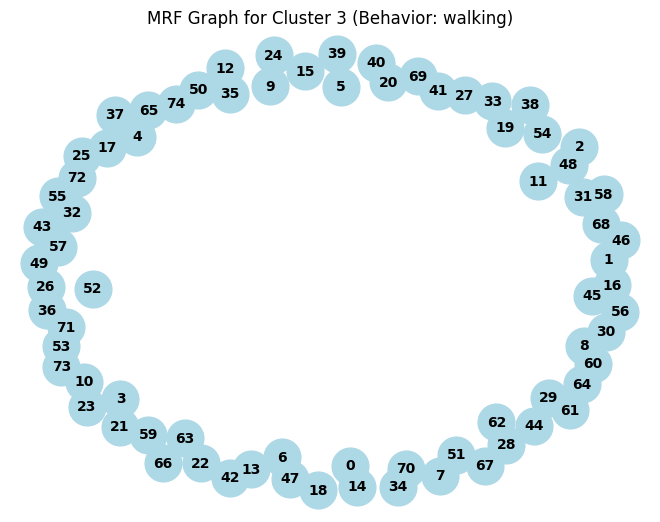

Number of nodes: 75
Number of edges: 0
Average betweenness centrality by feature: {0: np.float64(0.0), 1: np.float64(0.0), 2: np.float64(0.0)}
Cluster 1 (Behavior: headbutt)


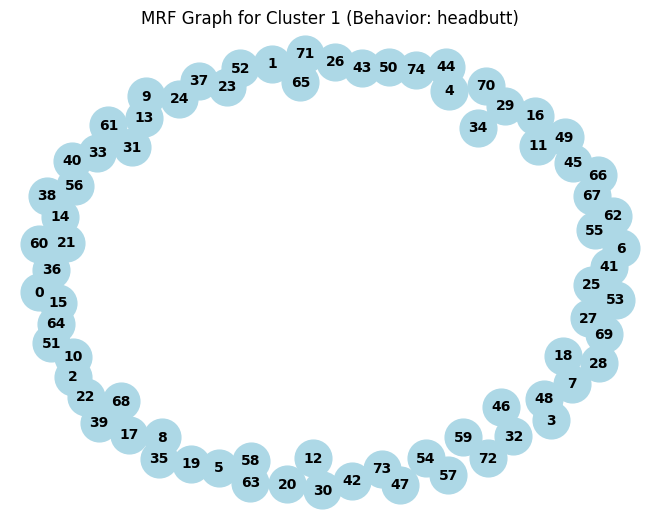

Number of nodes: 75
Number of edges: 0
Average betweenness centrality by feature: {0: np.float64(0.0), 1: np.float64(0.0), 2: np.float64(0.0)}
Cluster 0 (Behavior: drinking_milk)


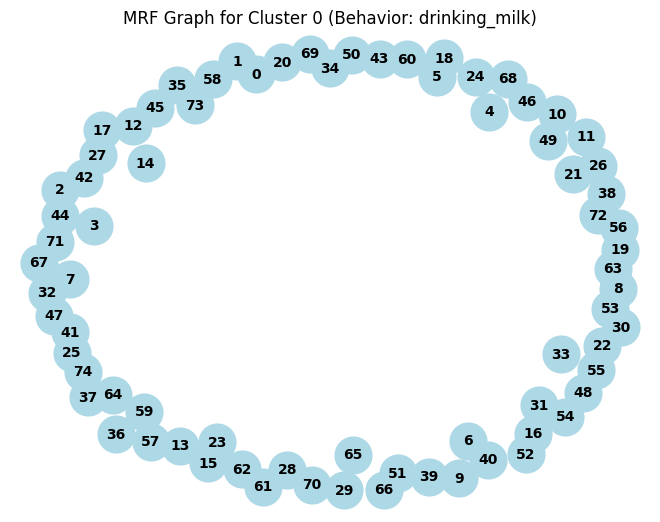

Number of nodes: 75
Number of edges: 0
Average betweenness centrality by feature: {0: np.float64(0.0), 1: np.float64(0.0), 2: np.float64(0.0)}


In [29]:
for i, mrf in mrfs.items():
    j = mapping[i]
    behavior = behaviour_mapping[j]
    print(f"Cluster {j} (Behavior: {behavior})")
    analyze_mrf(mrf, title=f"MRF Graph for Cluster {j} (Behavior: {behavior})")